In [ ]:
!pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.3/591.3 KB 19.7 MB/s eta 0:00:00


In [ ]:
#import các thư viện
import pandas as pd
import numpy as np
from underthesea import pos_tag
from collections import defaultdict
import math
import ast
import unicodedata as ud
import re
from sklearn.metrics import accuracy_score

In [ ]:
#Load data từ google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1. Tách từ


In [ ]:
sentences_original = open('/content/drive/MyDrive/CS221/Ngữ liệu/original.txt', encoding='utf-8').readlines() #Lấy dữ liệu gồm các câu trong dataset đã chuẩn bị
sentences_splited = [sentence.split(' ') for sentence in sentences_original]

In [ ]:
print('Số lượng các câu có trong file: ', len(sentences_original))
sentences_original[0:3]

Số lượng các câu có trong file:  40


['Bộ Kế hoạch và Đầu tư xác định 19 chỉ tiêu cụ thể về kinh tế , xã hội và môi trường của Đông Nam Bộ đến năm 2030 .\n',
 'Bộ Thông tin và Truyền thông phối hợp với Bộ Tư pháp và các bộ , cơ quan liên quan , rà soát , hoàn thiện quy định pháp luật bảo đảm thực hiện tốt nhiệm vụ truyền thông chính sách .\n',
 'Các hậu vệ biên của Anh dè chừng , không dám thường xuyên dâng cao trong khi hai trung vệ phải để mắt tới những pha thâm nhập bất ngờ của McKennie .\n']

In [ ]:
with open('/content/drive/MyDrive/CS221/Ngữ liệu/original_tachtu.txt', encoding='utf-8') as f:
    manual_tokenize_sentences = []
    sentence = ''
    for word in f:
        if word == '\n':
            manual_tokenize_sentences.append(sentence.strip())
            sentence = ''
        else: sentence += word.replace('\n',' ')
manual_tokenize_sentences[0:3]

['Bộ_Kế_hoạch_và_Đầu_tư xác_định 19 chỉ_tiêu cụ_thể về kinh_tế , xã_hội và môi_trường của Đông_Nam_Bộ đến năm 2030 .',
 'Bộ_Thông_tin_và_Truyền_thông phối_hợp với Bộ_Tư_pháp và các bộ , cơ_quan liên_quan , rà_soát , hoàn_thiện quy_định pháp_luật bảo_đảm thực_hiện tốt nhiệm_vụ truyền_thông chính_sách .',
 'Các hậu_vệ biên của Anh dè_chừng , không dám thường_xuyên dâng cao trong khi hai trung_vệ phải để_mắt tới những pha thâm_nhập bất_ngờ của McKennie .']

In [ ]:
count_manual_tokenize_compounds = 0
for sentence in manual_tokenize_sentences:
    for word in sentence.split():
        if '_' in word: count_manual_tokenize_compounds += 1
print('Số lượng từ ghép khi tách từ thủ công:', count_manual_tokenize_compounds)

Số lượng từ ghép khi tách từ thủ công: 233


##1.1 Longest matching


In [ ]:
#Tách câu thành các thành phần nhỏ bằng hàm syllablize
def syllablize(sentence):
    word = '\w+'
    non_word = '[^\w\s]'
    digits = '\d+([\.,_]\d+)+'
    
    patterns = []
    patterns.extend([word, non_word, digits])
    patterns = f"({'|'.join(patterns)})"
    
    sentence = ud.normalize('NFC', sentence)
    tokens = re.findall(patterns, sentence, re.UNICODE)
    return [token[0] for token in tokens]

In [ ]:
def longest_matching(sentence, bi_grams, tri_grams):
    syllables = syllablize(sentence)
    syl_len = len(syllables)
    
    curr_id = 0
    word_list = []
    done = False
    
    while (curr_id < syl_len) and (not done):
        curr_word = syllables[curr_id]
        if curr_id >= syl_len - 1:
            word_list.append(curr_word)
            done = True
        else:
            next_word = syllables[curr_id + 1]
            pair_word = ' '.join([curr_word.lower(), next_word.lower()])
            if curr_id >= (syl_len - 2):
                if pair_word in bi_grams:
                    word_list.append('_'.join([curr_word, next_word]))
                    curr_id += 2
                else:
                    word_list.append(curr_word)
                    curr_id += 1
            else:
                next_next_word = syllables[curr_id + 2]
                triple_word = ' '.join([pair_word, next_next_word.lower()])
                if triple_word in tri_grams:
                    word_list.append('_'.join([curr_word, next_word, next_next_word]))
                    curr_id += 3
                elif pair_word in bi_grams:
                    word_list.append('_'.join([curr_word, next_word]))
                    curr_id += 2
                else:
                    word_list.append(curr_word)
                    curr_id += 1
    return word_list

In [ ]:
#Lấy các từ trong file định dạng {}
def load_n_grams(path):
    with open(path, encoding='utf8') as f:
        words = f.read()
        words = ast.literal_eval(words)
    return words

In [ ]:
#Load các file từ điển
tudien2amtiet = load_n_grams('/content/drive/MyDrive/CS221/Ngữ liệu/tudien2amtiet.txt')
tudien3amtiet = load_n_grams('/content/drive/MyDrive/CS221/Ngữ liệu/tudien3amtiet.txt')

In [ ]:
#Kiểm tra thuật toán longest matching với câu đơn giản
longest_matching('Trong 12 tháng qua , Việt Nam đã thực hiện xuất sắc chuyển đổi sang quản lý bền vững Covid-19 .', tudien2amtiet, tudien3amtiet)

['Trong',
 '12',
 'tháng',
 'qua',
 ',',
 'Việt',
 'Nam',
 'đã',
 'thực_hiện',
 'xuất_sắc',
 'chuyển_đổi',
 'sang',
 'quản_lý',
 'bền_vững',
 'Covid',
 '-',
 '19',
 '.']

In [ ]:
#Tách từ của tập dữ liệu
with open('/content/drive/MyDrive/CS221/Ngữ liệu/Generate/longest_matching.txt', 'w', encoding='utf-8') as f:
    longest_matching_sentences = []
    for sentence in sentences_original:
        word_list = longest_matching(sentence, tudien2amtiet, tudien3amtiet)
        longest_matching_sentences.append(' '.join(word_list))
        for word in word_list: f.write(word + '\n')
        if sentence != sentences_original[-1]: f.write('\n')
    f.write('\n')
longest_matching_sentences[0:3]

['Bộ Kế hoạch và Đầu_tư xác_định 19 chỉ_tiêu cụ_thể về kinh_tế , xã_hội và môi_trường của Đông Nam Bộ đến năm 2030 .',
 'Bộ Thông tin và Truyền_thông phối_hợp với Bộ_Tư_pháp và các bộ , cơ_quan liên_quan , rà_soát , hoàn_thiện quy_định pháp luật bảo_đảm thực_hiện tốt nhiệm_vụ truyền_thông chính_sách .',
 'Các hậu_vệ_biên của Anh dè_chừng , không dám thường_xuyên dâng_cao trong_khi hai trung_vệ phải để_mắt tới những pha thâm_nhập bất_ngờ của McKennie .']

In [ ]:
count_longest_matching_compounds = 0
for sentence in longest_matching_sentences:
    for word in sentence.split():
        if '_' in word: count_longest_matching_compounds += 1
print('Số lượng từ ghép khi tách từ bằng thuật toán Longest Matching:', count_longest_matching_compounds)

Số lượng từ ghép khi tách từ bằng thuật toán Longest Matching: 222


##1.2 Underthesea

In [ ]:
from underthesea import word_tokenize
with open('/content/drive/MyDrive/CS221/Ngữ liệu/Generate/undersea.txt', 'w', encoding='utf-8') as f:
  undersea_sentences =[]
  for sentence in sentences_original:
    a=[]
    word_list = word_tokenize(sentence, format="text")
    undersea_sentences.append(''.join(word_list))
    a = word_list.split()
    for word in a: f.write(word+'\n')
    if sentence != sentences_original[-1]: f.write('\n')
  f.write('\n')
undersea_sentences[0:3]

['Bộ Kế_hoạch và Đầu_tư xác_định 19 chỉ_tiêu cụ_thể về kinh_tế , xã_hội và môi_trường của Đông_Nam_Bộ đến năm 2030 .',
 'Bộ Thông_tin và Truyền_thông phối_hợp với Bộ_Tư_pháp và các bộ , cơ_quan liên_quan , rà_soát , hoàn_thiện quy_định pháp_luật bảo_đảm thực_hiện tốt nhiệm_vụ truyền_thông chính_sách .',
 'Các hậu_vệ biên của Anh dè_chừng , không dám thường_xuyên dâng cao trong khi hai trung_vệ phải để mắt tới những pha thâm_nhập bất_ngờ của McKennie .']

In [ ]:
count_undertheseacompounds = 0
for sentence in undersea_sentences:
    for word in sentence.split():
        if '_' in word: count_undertheseacompounds += 1
print('Số lượng từ ghép khi tách từ bằng thư viện Underthesea:', count_undertheseacompounds)

Số lượng từ ghép khi tách từ bằng thư viện Underthesea: 235


##1.3 Đánh giá kết quả

In [ ]:
#Hàm đánh giá kết quả trả về của từng câu
def count_correct_words(pred, source, n_grams=3):
    pred_words = pred.split()
    source_words = source.split()
    
    total_true, tp = 0, 0
    total_errors, fp = 0, 0
    
    idx = 0
    while idx < len(pred_words):
        if pred_words[idx] not in source_words[idx:(idx + n_grams)]: 
            if '_' in pred_words[idx]: fp += 1
            del pred_words[idx]
            total_errors += 1
        else: idx += 1
    
    idx = 0
    while idx < len(source_words):
        if source_words[idx] not in pred_words[idx:(idx + n_grams)]: 
            del source_words[idx]
        else: idx += 1
    
    if len(pred_words) < len(source_words): words = pred_words
    else: words = source_words
    
    for idx in range (len(words)):
        if pred_words[idx] == source_words[idx]:
            if '_' in pred_words[idx]: tp += 1 
            total_true += 1
                    
    return total_true, total_errors, tp, fp

In [ ]:
print(count_correct_words('Việt Nam đã thực_hiện xuất_sắc chuyển_đổi sang quản_lý bền_vững','Việt_Nam đã thực_hiện xuất_sắc chuyển_đổi sang quản_lý bền_vững'))

(7, 2, 5, 0)


In [ ]:
def tokenize_evaluation(pred, source, n_grams=3):
    total_true = 0
    total_errors = 0
    total_words = 0
    
    pred_tp = 0
    pred_fp = 0
    
    for pred_sentence, source_sentence in zip(pred, source):
        total_words += len(source_sentence.split())
        if pred_sentence != source_sentence:
            true, error, tp, fp = count_correct_words(pred_sentence, source_sentence, n_grams)
            total_true += true 
            total_errors += error
            pred_tp += tp
            pred_fp += fp
        else:
            for word in source_sentence.split():
                if '_' in word: pred_tp += 1
                total_true += 1
    return {
        'Accuracy': total_true / total_words, 
        'Precision': pred_tp / (pred_tp + pred_fp),
        'Recall': pred_tp / count_manual_tokenize_compounds,
        'True Positive': pred_tp, 
        'False Positive': pred_fp,
        'Total True': total_true, 
        'Total Errors': total_errors
    }

In [ ]:
for i,j in zip(longest_matching_sentences, manual_tokenize_sentences):
  print(j.split())

['Bộ_Kế_hoạch_và_Đầu_tư', 'xác_định', '19', 'chỉ_tiêu', 'cụ_thể', 'về', 'kinh_tế', ',', 'xã_hội', 'và', 'môi_trường', 'của', 'Đông_Nam_Bộ', 'đến', 'năm', '2030', '.']
['Bộ_Thông_tin_và_Truyền_thông', 'phối_hợp', 'với', 'Bộ_Tư_pháp', 'và', 'các', 'bộ', ',', 'cơ_quan', 'liên_quan', ',', 'rà_soát', ',', 'hoàn_thiện', 'quy_định', 'pháp_luật', 'bảo_đảm', 'thực_hiện', 'tốt', 'nhiệm_vụ', 'truyền_thông', 'chính_sách', '.']
['Các', 'hậu_vệ', 'biên', 'của', 'Anh', 'dè_chừng', ',', 'không', 'dám', 'thường_xuyên', 'dâng', 'cao', 'trong', 'khi', 'hai', 'trung_vệ', 'phải', 'để_mắt', 'tới', 'những', 'pha', 'thâm_nhập', 'bất_ngờ', 'của', 'McKennie', '.']
['Nam_giới', 'uống', 'sữa_đậu_nành', 'có', 'bị', 'vô_sinh', 'không', '?']
['Thời_gian', 'qua', ',', 'tại', 'các', 'trạm_thu_phí', 'cao_tốc', 'Pháp_Vân', '-', 'Cầu_Giẽ', 'đã', 'xảy', 'ra', 'một_số', 'vụ', 'ôtô', 'chạy', 'tốc_độ', 'cao', ',', 'tài_khoản', 'thu', 'phí', 'không', 'dừng', 'không', 'đủ', 'tiền', 'hoặc', 'lỗi', 'đọc', 'thẻ', 'khiến', 'barie'

In [ ]:
longest_matching_evaluation = tokenize_evaluation(longest_matching_sentences, manual_tokenize_sentences)
underthesea_evaluation =tokenize_evaluation(undersea_sentences, manual_tokenize_sentences)

In [ ]:
df = pd.DataFrame([longest_matching_evaluation, underthesea_evaluation], index=['Longest Matching','Untherthesea']).astype(object).T
df

,Longest Matching,Untherthesea
Accuracy,0.864454,0.984786
Precision,0.882353,0.952991
Recall,0.83691,0.957082
True Positive,195,223
False Positive,26,11
Total True,625,712
Total Errors,140,26


#2. Gán nhãn từ loại

##2.1. Tạo bộ dữ liệu

###2.1.1. Tập train

In [ ]:
completed_corpus = open('/content/drive/MyDrive/CS221/Ngữ liệu/gannhan_thucong.txt', encoding='utf-8').readlines()

In [ ]:
#Đếm số từ ở trong tập train
d=0
for i in completed_corpus:
  if i.split():d+=1
print(d)

731


In [ ]:
completed_corpus

['Bộ_Kế_hoạch_và_Đầu_tư\tNp\n',
 'xác_định\tV\n',
 '19\tM\n',
 'chỉ_tiêu\tN\n',
 'cụ_thể\tA\t\n',
 'về\tE\n',
 'kinh_tế\tN\n',
 ',\tCH\n',
 'xã_hội\tN\n',
 'và\tCc\n',
 'môi_trường\tN\n',
 'của\tE\n',
 'Đông_Nam_Bộ\tNp\n',
 'đến\tV\n',
 'năm\tN\n',
 '2030\tM\n',
 '.\tCH\n',
 '\n',
 'Bộ_Thông_tin_và_Truyền_thông\tNp\n',
 'phối_hợp\tV\n',
 'với C\n',
 'Bộ_Tư_pháp\tNp\n',
 'và\tCc\n',
 'các\tD\n',
 'bộ\tN\n',
 ',\tCH\n',
 'cơ_quan\tN\n',
 'liên_quan\tV\n',
 ',\tCH\n',
 'rà_soát\tV\n',
 ',\tCH\n',
 'hoàn_thiện\tV\n',
 'quy_định\tN\n',
 'pháp_luật\tN\n',
 'bảo_đảm\tV\n',
 'thực_hiện\tV\n',
 'tốt\tA\n',
 'nhiệm_vụ\tN\n',
 'truyền_thông\tV\n',
 'chính_sách\tN\n',
 '.\tCH\n',
 '\n',
 'Các\tD\n',
 'hậu_vệ\tN\n',
 'biên\tN\n',
 'của\tE\n',
 'Anh\tNp\n',
 'dè_chừng\tV\n',
 ',\tCH\n',
 'không\tA\n',
 'dám\tV\n',
 'thường_xuyên\tA\n',
 'dâng\tV\n',
 'cao\tA\n',
 'trong\tE\n',
 'khi\tN\n',
 'hai\tM\n',
 'trung_vệ\tN\n',
 'phải\tV\n',
 'để_mắt\tV\n',
 'tới\tE\n',
 'những\tD\n',
 'pha\tN\n',
 'thâm_nh

In [ ]:
#hàm đếm số tag ở trong tập
def plot_tag_counts(gold):
    tags = [word_tag.split()[1] for word_tag in gold if word_tag.split()]
    tag_counts = pd.DataFrame(tags)[0].value_counts()
    tag_counts.plot.bar(rot=0, width=0.7, legend=False, figsize=(15, 5))
    return pd.DataFrame(tag_counts).T.assign(Total=tag_counts.sum()) 

,N,V,A,CH,E,P,C,R,Np,M,D,Cc,B,I,X,Nu,Y,Total
0,205,140,77,77,40,36,34,31,23,23,22,7,5,5,3,2,1,731


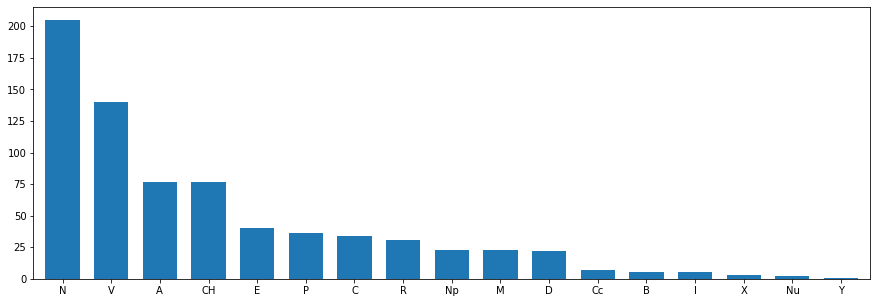

In [ ]:
#Thống kê các tag có trog tập
plot_tag_counts(completed_corpus)

###2.1.2. Tập test 

In [ ]:
test=open('/content/drive/MyDrive/CS221/Ngữ liệu/test_khongunk.txt', encoding='utf-8').readlines()
test_completed=open('/content/drive/MyDrive/CS221/Ngữ liệu/test_khongunk_gannhan.txt', encoding='utf-8').readlines()

,N,V,CH,A,R,P,C,E,Np,M,Total
0,22,21,10,9,6,6,4,3,1,1,83


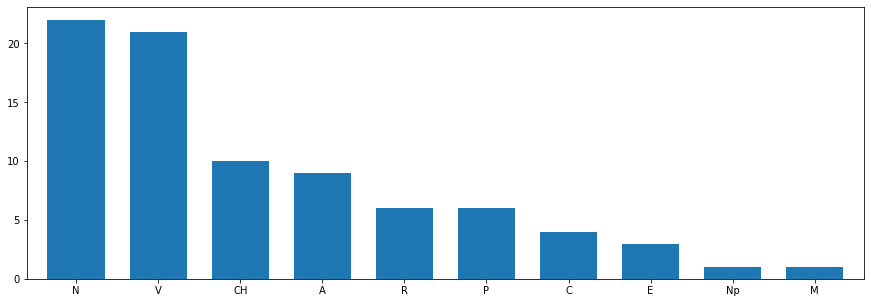

In [ ]:
plot_tag_counts(test_completed)

##2.2. HMM (Hidden Markov Model)

###2.2.1. Khởi tạo các tập từ điển từ tập train để tạo các ma trận

In [ ]:
Transition=defaultdict(int) #từ điển Transition giúp tạo ma trận chuyển tiếp
emis=defaultdict(int) #từ điển emis giúp tạo ma trận phát xạ
prev_tag = '--s--'
tagd=defaultdict(int) #từ điển tagd đếm số lần xuất hiện của các nhãn
tagd[prev_tag]+=1
dem=0
for word_tag in completed_corpus:
        if word_tag.split():
          word, tag = word_tag.split()
          Transition[(prev_tag, tag)] += 1
          emis[(word.lower(),tag)]+=1
          prev_tag = tag
          tagd[tag]+=1
        else:
          prev_tag='--s--'
          tagd[prev_tag]+=1

In [ ]:
Transition

defaultdict(int,
            {('--s--', 'Np'): 2,
             ('Np', 'V'): 6,
             ('V', 'M'): 3,
             ('M', 'N'): 14,
             ('N', 'A'): 27,
             ('A', 'E'): 8,
             ('E', 'N'): 20,
             ('N', 'CH'): 25,
             ('CH', 'N'): 9,
             ('N', 'Cc'): 3,
             ('Cc', 'N'): 2,
             ('N', 'E'): 16,
             ('E', 'Np'): 5,
             ('V', 'N'): 45,
             ('N', 'M'): 6,
             ('M', 'CH'): 2,
             ('V', 'C'): 5,
             ('C', 'Np'): 2,
             ('Np', 'Cc'): 2,
             ('Cc', 'D'): 1,
             ('D', 'N'): 22,
             ('N', 'V'): 43,
             ('V', 'CH'): 9,
             ('CH', 'V'): 8,
             ('N', 'N'): 41,
             ('V', 'V'): 29,
             ('V', 'A'): 22,
             ('A', 'N'): 16,
             ('--s--', 'D'): 4,
             ('CH', 'A'): 4,
             ('A', 'V'): 11,
             ('V', 'E'): 10,
             ('E', 'D'): 4,
             ('Np', 'C

In [ ]:
emis

defaultdict(int,
            {('bộ_kế_hoạch_và_đầu_tư', 'Np'): 1,
             ('xác_định', 'V'): 1,
             ('19', 'M'): 1,
             ('chỉ_tiêu', 'N'): 1,
             ('cụ_thể', 'A'): 1,
             ('về', 'E'): 4,
             ('kinh_tế', 'N'): 1,
             (',', 'CH'): 33,
             ('xã_hội', 'N'): 2,
             ('và', 'Cc'): 7,
             ('môi_trường', 'N'): 1,
             ('của', 'E'): 15,
             ('đông_nam_bộ', 'Np'): 1,
             ('đến', 'V'): 1,
             ('năm', 'N'): 2,
             ('2030', 'M'): 1,
             ('.', 'CH'): 39,
             ('bộ_thông_tin_và_truyền_thông', 'Np'): 1,
             ('phối_hợp', 'V'): 1,
             ('với', 'C'): 9,
             ('bộ_tư_pháp', 'Np'): 1,
             ('các', 'D'): 13,
             ('bộ', 'N'): 1,
             ('cơ_quan', 'N'): 1,
             ('liên_quan', 'V'): 1,
             ('rà_soát', 'V'): 1,
             ('hoàn_thiện', 'V'): 1,
             ('quy_định', 'N'): 1,
             ('pháp_luậ

In [ ]:
tagd

defaultdict(int,
            {'--s--': 40,
             'Np': 23,
             'V': 140,
             'M': 23,
             'N': 205,
             'A': 77,
             'E': 40,
             'CH': 77,
             'Cc': 7,
             'C': 34,
             'D': 22,
             'R': 31,
             'B': 5,
             'Nu': 2,
             'P': 36,
             'X': 3,
             'Y': 1,
             'I': 5})

In [ ]:
#Thêm từ 'unk' vào trong từ điển emis, dùng để sau này tính toán với những từ không nằm trong tập từ điển tạo từ tập train
for i in range(len(tagd)):
  emis[('unk', sorted(tagd.keys())[i])]

In [ ]:
emis

defaultdict(int,
            {('bộ_kế_hoạch_và_đầu_tư', 'Np'): 1,
             ('xác_định', 'V'): 1,
             ('19', 'M'): 1,
             ('chỉ_tiêu', 'N'): 1,
             ('cụ_thể', 'A'): 1,
             ('về', 'E'): 4,
             ('kinh_tế', 'N'): 1,
             (',', 'CH'): 33,
             ('xã_hội', 'N'): 2,
             ('và', 'Cc'): 7,
             ('môi_trường', 'N'): 1,
             ('của', 'E'): 15,
             ('đông_nam_bộ', 'Np'): 1,
             ('đến', 'V'): 1,
             ('năm', 'N'): 2,
             ('2030', 'M'): 1,
             ('.', 'CH'): 39,
             ('bộ_thông_tin_và_truyền_thông', 'Np'): 1,
             ('phối_hợp', 'V'): 1,
             ('với', 'C'): 9,
             ('bộ_tư_pháp', 'Np'): 1,
             ('các', 'D'): 13,
             ('bộ', 'N'): 1,
             ('cơ_quan', 'N'): 1,
             ('liên_quan', 'V'): 1,
             ('rà_soát', 'V'): 1,
             ('hoàn_thiện', 'V'): 1,
             ('quy_định', 'N'): 1,
             ('pháp_luậ

###2.2.2. Ma trận chuyển tiếp MatrixA

In [ ]:
#hàm khởi tạo ma trận chuyển tiếp MatrixA với tham số smoothing=1 và từ điển transsub 
def create_transition(tag_counts, Transition):
    all_tags = sorted(tag_counts.keys())  #tất cả các nhãn xuất hiện trong tập train đã được sắp xếp
    num_tags = len(all_tags)              #số lượng nhãn
    
    A = np.zeros((num_tags, num_tags-1))
    transsub=defaultdict(int)
    for i in range(num_tags):
        for j in range(num_tags-1):
            count = 0
            key = (all_tags[i], all_tags[j+1])
            if key in Transition: count = Transition[key]
                
            count_prev_tag = tag_counts[all_tags[i]]
            A[i,j]=(count + 1) / (count_prev_tag + num_tags-1)
            transsub[(all_tags[i], all_tags[j+1])] = (count + 1) / (count_prev_tag + num_tags-1)
    return A,transsub

In [ ]:
#tạo ma trận matrixA và từ điển transsub
matrixA, transsub=create_transition(tagd, Transition)

matrixA

array([[0.01754386, 0.01754386, 0.05263158, 0.01754386, 0.01754386,
        0.0877193 , 0.05263158, 0.01754386, 0.0877193 , 0.33333333,
        0.05263158, 0.01754386, 0.14035088, 0.01754386, 0.03508772,
        0.01754386, 0.01754386],
       [0.07446809, 0.0106383 , 0.09574468, 0.19148936, 0.0212766 ,
        0.0212766 , 0.09574468, 0.0212766 , 0.05319149, 0.18085106,
        0.0106383 , 0.0106383 , 0.0212766 , 0.04255319, 0.12765957,
        0.0106383 , 0.0106383 ],
       [0.09090909, 0.04545455, 0.04545455, 0.13636364, 0.04545455,
        0.04545455, 0.04545455, 0.04545455, 0.04545455, 0.04545455,
        0.04545455, 0.04545455, 0.04545455, 0.09090909, 0.09090909,
        0.04545455, 0.04545455],
       [0.09803922, 0.01960784, 0.01960784, 0.03921569, 0.01960784,
        0.05882353, 0.01960784, 0.01960784, 0.03921569, 0.23529412,
        0.05882353, 0.01960784, 0.07843137, 0.07843137, 0.15686275,
        0.01960784, 0.01960784],
       [0.05319149, 0.0106383 , 0.0212766 , 0.010638

In [ ]:
#hiển thị ma trận chuyển tiếp matrixA
df = pd.DataFrame(
    matrixA, 
    index = sorted(tagd.keys()), 
    columns = sorted(tagd.keys())[1:]
)
df

,A,B,C,CH,Cc,D,E,I,M,N,Np,Nu,P,R,V,X,Y
--s--,0.017544,0.017544,0.052632,0.017544,0.017544,0.087719,0.052632,0.017544,0.087719,0.333333,0.052632,0.017544,0.140351,0.017544,0.035088,0.017544,0.017544
A,0.074468,0.010638,0.095745,0.191489,0.021277,0.021277,0.095745,0.021277,0.053191,0.180851,0.010638,0.010638,0.021277,0.042553,0.127660,0.010638,0.010638
B,0.090909,0.045455,0.045455,0.136364,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.090909,0.090909,0.045455,0.045455
C,0.098039,0.019608,0.019608,0.039216,0.019608,0.058824,0.019608,0.019608,0.039216,0.235294,0.058824,0.019608,0.078431,0.078431,0.156863,0.019608,0.019608
CH,0.053191,0.010638,0.021277,0.010638,0.010638,0.031915,0.042553,0.010638,0.021277,0.106383,0.042553,0.010638,0.031915,0.042553,0.095745,0.021277,0.010638
Cc,0.041667,0.041667,0.041667,0.041667,0.041667,0.083333,0.041667,0.041667,0.041667,0.125000,0.083333,0.041667,0.041667,0.041667,0.166667,0.041667,0.041667
D,0.025641,0.025641,0.025641,0.025641,0.025641,0.025641,0.025641,0.025641,0.025641,0.589744,0.025641,0.025641,0.025641,0.025641,0.025641,0.025641,0.025641
E,0.035088,0.017544,0.035088,0.017544,0.017544,0.087719,0.017544,0.017544,0.017544,0.368421,0.105263,0.017544,0.140351,0.035088,0.035088,0.017544,0.017544
I,0.045455,0.045455,0.045455,0.181818,0.045455,0.045455,0.045455,0.090909,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.090909,0.045455,0.045455
M,0.025000,0.025000,0.050000,0.075000,0.025000,0.025000,0.025000,0.025000,0.100000,0.375000,0.025000,0.075000,0.025000,0.025000,0.050000,0.025000,0.025000


In [ ]:
transsub

defaultdict(int,
            {('--s--', 'A'): 0.017543859649122806,
             ('--s--', 'B'): 0.017543859649122806,
             ('--s--', 'C'): 0.05263157894736842,
             ('--s--', 'CH'): 0.017543859649122806,
             ('--s--', 'Cc'): 0.017543859649122806,
             ('--s--', 'D'): 0.08771929824561403,
             ('--s--', 'E'): 0.05263157894736842,
             ('--s--', 'I'): 0.017543859649122806,
             ('--s--', 'M'): 0.08771929824561403,
             ('--s--', 'N'): 0.3333333333333333,
             ('--s--', 'Np'): 0.05263157894736842,
             ('--s--', 'Nu'): 0.017543859649122806,
             ('--s--', 'P'): 0.14035087719298245,
             ('--s--', 'R'): 0.017543859649122806,
             ('--s--', 'V'): 0.03508771929824561,
             ('--s--', 'X'): 0.017543859649122806,
             ('--s--', 'Y'): 0.017543859649122806,
             ('A', 'A'): 0.07446808510638298,
             ('A', 'B'): 0.010638297872340425,
             ('A', 'C'): 0.0

###2.2.3. Ma trận phát xạ MatrixB

In [ ]:
#từ điển số lần xuất hiện của các từ trong tập train
wordd=defaultdict(int) 
for word_tag in completed_corpus:
        if word_tag.split():
          word, tag = word_tag.split()
          wordd[word.lower()]+=1
wordd['unk']=0  #thêm từ 'unk' vào từ điển để tính toán ma trận phát xạ

In [ ]:
wordd

defaultdict(int,
            {'bộ_kế_hoạch_và_đầu_tư': 1,
             'xác_định': 1,
             '19': 1,
             'chỉ_tiêu': 1,
             'cụ_thể': 1,
             'về': 4,
             'kinh_tế': 1,
             ',': 33,
             'xã_hội': 2,
             'và': 10,
             'môi_trường': 1,
             'của': 15,
             'đông_nam_bộ': 1,
             'đến': 4,
             'năm': 3,
             '2030': 1,
             '.': 39,
             'bộ_thông_tin_và_truyền_thông': 1,
             'phối_hợp': 1,
             'với': 9,
             'bộ_tư_pháp': 1,
             'các': 15,
             'bộ': 1,
             'cơ_quan': 1,
             'liên_quan': 1,
             'rà_soát': 1,
             'hoàn_thiện': 1,
             'quy_định': 1,
             'pháp_luật': 1,
             'bảo_đảm': 1,
             'thực_hiện': 1,
             'tốt': 1,
             'nhiệm_vụ': 1,
             'truyền_thông': 1,
             'chính_sách': 2,
             'hậu_vệ': 1,
 

In [ ]:
#số từ trong tập từ điển wordd
len(wordd)

425

In [ ]:
emis

defaultdict(int,
            {('bộ_kế_hoạch_và_đầu_tư', 'Np'): 1,
             ('xác_định', 'V'): 1,
             ('19', 'M'): 1,
             ('chỉ_tiêu', 'N'): 1,
             ('cụ_thể', 'A'): 1,
             ('về', 'E'): 4,
             ('kinh_tế', 'N'): 1,
             (',', 'CH'): 33,
             ('xã_hội', 'N'): 2,
             ('và', 'Cc'): 7,
             ('môi_trường', 'N'): 1,
             ('của', 'E'): 15,
             ('đông_nam_bộ', 'Np'): 1,
             ('đến', 'V'): 1,
             ('năm', 'N'): 2,
             ('2030', 'M'): 1,
             ('.', 'CH'): 39,
             ('bộ_thông_tin_và_truyền_thông', 'Np'): 1,
             ('phối_hợp', 'V'): 1,
             ('với', 'C'): 9,
             ('bộ_tư_pháp', 'Np'): 1,
             ('các', 'D'): 13,
             ('bộ', 'N'): 1,
             ('cơ_quan', 'N'): 1,
             ('liên_quan', 'V'): 1,
             ('rà_soát', 'V'): 1,
             ('hoàn_thiện', 'V'): 1,
             ('quy_định', 'N'): 1,
             ('pháp_luậ

In [ ]:
#Hàm khởi tạo ma trận phát xạ matrixB và từ điển emissub
def create_emission(tag_counts, emis,wordd):
    all_tags = sorted(tag_counts.keys()) #tất cả các nhãn đã được sắp xếp
    all_words= sorted(wordd.keys()) #Tất cả các từ trong tập từ điển wordd
    num_tags = len(tag_counts)  #số nhãn của tập tagd
    num_words = len(wordd)  #Số lượng từ trong tập wordd (vd như từ 'ở' xuất hiện 2 lần thì chỉ tính là 1 từ, từ 'đang' xuất hiện 3 lần cũng tính là 1 từ )
    B = np.zeros((num_tags-1, num_words))
    emissub =defaultdict(int)
    for i in range(num_tags-1):
        for j in range(num_words):
            count = 0
            key = (all_words[j], all_tags[i+1])
            if key in emis.keys(): count = emis[key]
                
            count_tag = tag_counts[all_tags[i+1]]
            emissub[key]=(count + 1) / (count_tag + num_words)
            B[i, j] = (count + 1) / (count_tag + num_words)
    return B,emissub

In [ ]:
#tạo ma trận phát xạ matrixB và từ điển emissub
matrixB,emissub=create_emission(tagd, emis, wordd )
matrixB

array([[0.00199203, 0.00199203, 0.00199203, ..., 0.00199203, 0.00199203,
        0.00199203],
       [0.00232558, 0.00232558, 0.00232558, ..., 0.00232558, 0.00232558,
        0.00232558],
       [0.00217865, 0.00217865, 0.00217865, ..., 0.00217865, 0.00217865,
        0.00217865],
       ...,
       [0.00176991, 0.00176991, 0.00176991, ..., 0.00176991, 0.00353982,
        0.00353982],
       [0.00233645, 0.00233645, 0.00233645, ..., 0.00233645, 0.00233645,
        0.00233645],
       [0.00234742, 0.00234742, 0.00234742, ..., 0.00234742, 0.00234742,
        0.00234742]])

In [ ]:
#từ điển emissub
emissub

defaultdict(int,
            {(',', 'A'): 0.00199203187250996,
             ('-', 'A'): 0.00199203187250996,
             ('.', 'A'): 0.00199203187250996,
             ('10', 'A'): 0.00199203187250996,
             ('10/2020', 'A'): 0.00199203187250996,
             ('19', 'A'): 0.00199203187250996,
             ('19/5', 'A'): 0.00199203187250996,
             ('2', 'A'): 0.00199203187250996,
             ('2019', 'A'): 0.00199203187250996,
             ('2030', 'A'): 0.00199203187250996,
             ('4.000', 'A'): 0.00199203187250996,
             ('740', 'A'): 0.00199203187250996,
             (':', 'A'): 0.00199203187250996,
             ('?', 'A'): 0.00199203187250996,
             ('anh', 'A'): 0.00199203187250996,
             ('ba', 'A'): 0.00199203187250996,
             ('barca', 'A'): 0.00199203187250996,
             ('barie', 'A'): 0.00199203187250996,
             ('biên', 'A'): 0.00199203187250996,
             ('biếc', 'A'): 0.00398406374501992,
             ('biến', '

In [ ]:
#hiển thị ma trận phát xạ MatrixB
df = pd.DataFrame(
    matrixB, 
    index = sorted(tagd.keys())[1:], 
    columns = sorted(wordd.keys())
)
df

,",",-,.,10,10/2020,19,19/5,2,2019,2030,...,đỏ,đối_tượng,đồng,đội,động_lực,đủ,ước_mơ,ấy,ở,ứng_dụng
A,0.001992,0.001992,0.001992,0.001992,0.001992,0.001992,0.001992,0.001992,0.001992,0.001992,...,0.003984,0.001992,0.001992,0.001992,0.001992,0.003984,0.001992,0.001992,0.001992,0.001992
B,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,...,0.002326,0.004651,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326
C,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179,...,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179,0.002179
CH,0.067729,0.007968,0.079681,0.001992,0.001992,0.001992,0.001992,0.001992,0.001992,0.001992,...,0.001992,0.001992,0.001992,0.001992,0.001992,0.001992,0.001992,0.001992,0.001992,0.001992
Cc,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315,...,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315
D,0.002237,0.002237,0.002237,0.002237,0.002237,0.002237,0.002237,0.002237,0.002237,0.002237,...,0.002237,0.002237,0.002237,0.002237,0.002237,0.002237,0.002237,0.002237,0.002237,0.002237
E,0.002151,0.002151,0.002151,0.002151,0.002151,0.002151,0.002151,0.002151,0.002151,0.002151,...,0.002151,0.002151,0.002151,0.002151,0.002151,0.002151,0.002151,0.002151,0.002151,0.002151
I,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,...,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326,0.002326
M,0.002232,0.002232,0.002232,0.004464,0.002232,0.004464,0.002232,0.002232,0.004464,0.004464,...,0.002232,0.002232,0.002232,0.002232,0.002232,0.002232,0.002232,0.002232,0.002232,0.002232
N,0.001587,0.001587,0.001587,0.001587,0.001587,0.001587,0.001587,0.003175,0.001587,0.001587,...,0.001587,0.004762,0.001587,0.003175,0.003175,0.001587,0.003175,0.001587,0.001587,0.003175


##2.3. Thuật toán Viterbi

Tạo ma 2 ma trận C và D cho thuật toán

In [ ]:
#Hàm khởi tạo 2 ma trận C D cho thuật toán Viterbi
def created(tagd,L,emissub,transsub):
  C=defaultdict(int)
  D=defaultdict(int)
  hang=sorted(tagd.keys())
  cot=len(L)
  for i in range (1,len(hang)):
    if L[0][0][0:3]=='unk': #nếu từ đầu trong câu là unk
      C[(hang[i],L[0][0])]=emissub[(L[0][0][0:3],hang[i])]*transsub[('--s--',hang[i])]
      D[(hang[i],L[0][0])]=0
    else: #nếu không
      C[(hang[i],L[0][0])]=emissub[(L[0][0],hang[i])]*transsub[('--s--',hang[i])]
      D[(hang[i],L[0][0])]=0
  return C,D
#Hoàn thiện C,D
def completed(tagd,L,emissub, transsub, C):
  hang=sorted(tagd.keys())
  for j in range(1,len(L)):
    for i in range(1,len(hang)):
      max=0
      for k in range(1,len(hang)):
        if L[j][0][0:len(L[j][0])-1].split() in L:  #Vì nhóm em có xử lý nếu từ xuát hiện thêm 1 lần ở trong câu thì sẽ thêm 1 số ở sau từ đó
                                            #Ví dụ: từ 'dạy_học' xuất hiện lần thứ 2 thì nó sẽ trở thành 'dạy_học0', lần thứ 3 thì là 'dạy_học1'
          t=C[(hang[k],L[j-1][0])]*transsub[(hang[k],hang[i])]*emissub[(L[j][0][0:len(L[j][0])-1],hang[i])]
        else: 
          if L[j][0][0:3]=='unk':
            t=C[(hang[k],L[j-1][0])]*transsub[(hang[k],hang[i])]*emissub[(L[j][0][0:3],hang[i])]
          else: t=C[(hang[k],L[j-1][0])]*transsub[(hang[k],hang[i])]*emissub[(L[j][0],hang[i])]
        if t>=max: 
          max=t
          vt=k
      C[(hang[i],L[j][0])]=max
      D[(hang[i],L[j][0])]=vt 

###2.3.1 Trên tập test

In [ ]:
test=open('/content/drive/MyDrive/CS221/Ngữ liệu/test_khongunk.txt', encoding='utf-8').readlines()

In [ ]:
traintu=open('/content/drive/MyDrive/CS221/Ngữ liệu/original_tachtu.txt', encoding='utf-8').readlines() #tập hợp các từ trong tập train đọc từ file tách từ để không bị dính nhãn
traintu

['Bộ_Kế_hoạch_và_Đầu_tư\n',
 'xác_định\n',
 '19\n',
 'chỉ_tiêu\n',
 'cụ_thể\n',
 'về\n',
 'kinh_tế\n',
 ',\n',
 'xã_hội\n',
 'và\n',
 'môi_trường\n',
 'của\n',
 'Đông_Nam_Bộ\n',
 'đến\n',
 'năm\n',
 '2030\n',
 '.\n',
 '\n',
 'Bộ_Thông_tin_và_Truyền_thông\n',
 'phối_hợp\n',
 'với\n',
 'Bộ_Tư_pháp\n',
 'và\n',
 'các\n',
 'bộ\n',
 ',\n',
 'cơ_quan\n',
 'liên_quan\n',
 ',\n',
 'rà_soát\n',
 ',\n',
 'hoàn_thiện\n',
 'quy_định\n',
 'pháp_luật\n',
 'bảo_đảm\n',
 'thực_hiện\n',
 'tốt\n',
 'nhiệm_vụ\n',
 'truyền_thông\n',
 'chính_sách\n',
 '.\n',
 '\n',
 'Các\n',
 'hậu_vệ\n',
 'biên\n',
 'của\n',
 'Anh\n',
 'dè_chừng\n',
 ',\n',
 'không\n',
 'dám\n',
 'thường_xuyên\n',
 'dâng\n',
 'cao\n',
 'trong\n',
 'khi\n',
 'hai\n',
 'trung_vệ\n',
 'phải\n',
 'để_mắt\n',
 'tới\n',
 'những\n',
 'pha\n',
 'thâm_nhập\n',
 'bất_ngờ\n',
 'của\n',
 'McKennie\n',
 '.\n',
 '\n',
 'Nam_giới\n',
 'uống\n',
 'sữa_đậu_nành\n',
 'có\n',
 'bị\n',
 'vô_sinh\n',
 'không\n',
 '?\n',
 '\n',
 'Thời_gian\n',
 'qua\n',
 ',\n',

In [ ]:
#Tạo mảng train từ mảng traintu để kiểm tra các từ trong tập test có nằm trong này không
train=[]
for word in traintu:
  train.append(word.strip().lower())  #chuyển chữ cái sang in thường
train

['bộ_kế_hoạch_và_đầu_tư',
 'xác_định',
 '19',
 'chỉ_tiêu',
 'cụ_thể',
 'về',
 'kinh_tế',
 ',',
 'xã_hội',
 'và',
 'môi_trường',
 'của',
 'đông_nam_bộ',
 'đến',
 'năm',
 '2030',
 '.',
 '',
 'bộ_thông_tin_và_truyền_thông',
 'phối_hợp',
 'với',
 'bộ_tư_pháp',
 'và',
 'các',
 'bộ',
 ',',
 'cơ_quan',
 'liên_quan',
 ',',
 'rà_soát',
 ',',
 'hoàn_thiện',
 'quy_định',
 'pháp_luật',
 'bảo_đảm',
 'thực_hiện',
 'tốt',
 'nhiệm_vụ',
 'truyền_thông',
 'chính_sách',
 '.',
 '',
 'các',
 'hậu_vệ',
 'biên',
 'của',
 'anh',
 'dè_chừng',
 ',',
 'không',
 'dám',
 'thường_xuyên',
 'dâng',
 'cao',
 'trong',
 'khi',
 'hai',
 'trung_vệ',
 'phải',
 'để_mắt',
 'tới',
 'những',
 'pha',
 'thâm_nhập',
 'bất_ngờ',
 'của',
 'mckennie',
 '.',
 '',
 'nam_giới',
 'uống',
 'sữa_đậu_nành',
 'có',
 'bị',
 'vô_sinh',
 'không',
 '?',
 '',
 'thời_gian',
 'qua',
 ',',
 'tại',
 'các',
 'trạm_thu_phí',
 'cao_tốc',
 'pháp_vân',
 '-',
 'cầu_giẽ',
 'đã',
 'xảy',
 'ra',
 'một_số',
 'vụ',
 'ôtô',
 'chạy',
 'tốc_độ',
 'cao',
 ',',
 't

In [ ]:
#Đếm số từ không xuất hiện trong tập từ điển tạo từ tập train (mảng train, ý của từ điển ở đây là danh sách các từ chứ không phải dictionary)
d=0
for i in range(len(test)):
  if test[i].strip().lower() not in train:
    print(test[i].strip().lower()) #in ra các từ không xuất hiện
    test[i]=test[i].replace(test[i].strip(),'unk') #thay thế các từ không xuất hiện đó bằng từ 'unk'
    d+=1

hóc_búa
đau_đầu
suốt
liền


In [ ]:
test #Tập test sau khi thay thế các từ không xuất hiện bằng 'unk'

['Việt_Nam\n',
 'đang\n',
 'thực_hiện\n',
 'nhiệm_vụ\n',
 'hoàn_thiện\n',
 'việc\n',
 'thay_đổi\n',
 'chính_sách\n',
 '.\n',
 '\n',
 'Mở_rộng\n',
 'mạng_lưới\n',
 'giao_dịch\n',
 'khẩu_trang\n',
 'là\n',
 'rất\n',
 'tiềm_năng\n',
 '.\n',
 '\n',
 'Phương_pháp\n',
 'ấy\n',
 'mang\n',
 'lại\n',
 'hiệu_quả\n',
 'đáng_kể\n',
 'với\n',
 'thế_giới\n',
 '.\n',
 '\n',
 'Cổ_động_viên\n',
 'từ_chối\n',
 'nói_chuyện\n',
 'với\n',
 'nhà_khoa_học\n',
 '.\n',
 '\n',
 'Hiện_thực\n',
 'dần\n',
 'được\n',
 'hoàn_thành\n',
 'qua\n',
 'cái\n',
 'tủ_lạnh\n',
 '.\n',
 '\n',
 'Màu\n',
 'xanh\n',
 'và\n',
 'màu\n',
 'đỏ\n',
 'rất\n',
 'đẹp\n',
 '.\n',
 '\n',
 'Đối_tượng\n',
 'nhiễm_bệnh\n',
 'đưa\n',
 'ra\n',
 'giải_pháp\n',
 'cho\n',
 'mình\n',
 '.\n',
 '\n',
 'Tương_lai\n',
 'bán_lẻ\n',
 'vật_liệu\n',
 'cao_cấp\n',
 'đã\n',
 'được\n',
 'hiện_thực\n',
 '.\n',
 '\n',
 'Câu_đố\n',
 'unk\n',
 'này\n',
 'làm\n',
 'tôi\n',
 'unk\n',
 'unk\n',
 '2\n',
 'năm\n',
 'unk\n',
 '.\n',
 '\n',
 'Anh\n',
 'ấy\n',
 'đề_cao\

In [ ]:

K=[]
d=0
viterbipredict=[]
for i in test:
  if i.split():
    if i.lower().split() in K:
      K.append((i.strip().lower()+str(d)).split())
      d+=1
    else: K.append(i.lower().split())
  else:
    d=0
    C,D=created(tagd,K,emissub,transsub)
    completed(tagd,K,emissub,transsub,C)
    #Tìm phần tử lớn nhất trong cột cuối cùng của C
    max=0
    hang=sorted(tagd.keys())
    for i in range(1,len(hang)):
      if C[(hang[i],K[len(K)-1][0])]>=max: 
        max=C[(hang[i],K[len(K)-1][0])]
        vt=i
    print(K)
    #tìm đường đi tốt nhất
    Best=[]
    Best.append(vt)
    dem=1
    while D[(hang[vt],K[len(K)-dem][0])]>0:
      
        Best.append(D[(hang[vt],K[len(K)-dem][0])])
        vt=D[(hang[vt],K[len(K)-dem][0])]
        dem+=1
    Best.reverse() #vì là truy vết ngược nên phải đảo vị trí lại
    for i in Best: 
      print(hang[i], end=" ")
      viterbipredict.append(hang[i]) #Tập lưu các nhãn được dự đoán để tính toán độ chính xác

    print(end="\n")
    K=[]
    
    
    




[['việt_nam'], ['đang'], ['thực_hiện'], ['nhiệm_vụ'], ['hoàn_thiện'], ['việc'], ['thay_đổi'], ['chính_sách'], ['.']]
P R V N V N V N CH 
[['mở_rộng'], ['mạng_lưới'], ['giao_dịch'], ['khẩu_trang'], ['là'], ['rất'], ['tiềm_năng'], ['.']]
D N V N C R A CH 
[['phương_pháp'], ['ấy'], ['mang'], ['lại'], ['hiệu_quả'], ['đáng_kể'], ['với'], ['thế_giới'], ['.']]
N P V V N A C N CH 
[['cổ_động_viên'], ['từ_chối'], ['nói_chuyện'], ['với'], ['nhà_khoa_học'], ['.']]
N V A C N CH 
[['hiện_thực'], ['dần'], ['được'], ['hoàn_thành'], ['qua'], ['cái'], ['tủ_lạnh'], ['.']]
N V V V V N N CH 
[['màu'], ['xanh'], ['và'], ['màu0'], ['đỏ'], ['rất'], ['đẹp'], ['.']]
N A C N A R A CH 
[['đối_tượng'], ['nhiễm_bệnh'], ['đưa'], ['ra'], ['giải_pháp'], ['cho'], ['mình'], ['.']]
N V V V N V N CH 
[['tương_lai'], ['bán_lẻ'], ['vật_liệu'], ['cao_cấp'], ['đã'], ['được'], ['hiện_thực'], ['.']]
N V N A R V N CH 
[['câu_đố'], ['unk'], ['này'], ['làm'], ['tôi'], ['unk0'], ['unk1'], ['2'], ['năm'], ['unk2'], ['.']]
N E P V V

In [ ]:
transsub

defaultdict(int,
            {('--s--', 'A'): 0.017543859649122806,
             ('--s--', 'B'): 0.017543859649122806,
             ('--s--', 'C'): 0.05263157894736842,
             ('--s--', 'CH'): 0.017543859649122806,
             ('--s--', 'Cc'): 0.017543859649122806,
             ('--s--', 'D'): 0.08771929824561403,
             ('--s--', 'E'): 0.05263157894736842,
             ('--s--', 'I'): 0.017543859649122806,
             ('--s--', 'M'): 0.08771929824561403,
             ('--s--', 'N'): 0.3333333333333333,
             ('--s--', 'Np'): 0.05263157894736842,
             ('--s--', 'Nu'): 0.017543859649122806,
             ('--s--', 'P'): 0.14035087719298245,
             ('--s--', 'R'): 0.017543859649122806,
             ('--s--', 'V'): 0.03508771929824561,
             ('--s--', 'X'): 0.017543859649122806,
             ('--s--', 'Y'): 0.017543859649122806,
             ('A', 'A'): 0.07446808510638298,
             ('A', 'B'): 0.010638297872340425,
             ('A', 'C'): 0.0

In [ ]:
emissub[('đức', 'A')]

0

In [ ]:
len(viterbipredict)

75

###2.3.2 Trên tập train

In [ ]:
train_word=open('/content/drive/MyDrive/CS221/Ngữ liệu/original_tachtu.txt', encoding='utf-8').readlines()
train_word.append('\n')

In [ ]:
K=[]
d=0
viterbipredicttrain=[]  #lưu các nhãn được gán bằng thuật toán Viterbi trên tập train
for i in train_word:
  if i.split():
    if i.lower().split() in K:
      K.append((i.strip().lower()+str(d)).split())
      d+=1
    else: K.append(i.lower().split())
  else:
    d=0
    C,D=created(tagd,K,emissub,transsub)
    completed(tagd,K,emissub,transsub,C)
    max=0
    hang=sorted(tagd.keys())
    for i in range(1,len(hang)):
      if C[(hang[i],K[len(K)-1][0])]>=max: 
        max=C[(hang[i],K[len(K)-1][0])]
        vt=i
    print(K)
    Best=[]
    Best.append(vt)
    dem=1
    while D[(hang[vt],K[len(K)-dem][0])]>0:
      
        Best.append(D[(hang[vt],K[len(K)-dem][0])])
        vt=D[(hang[vt],K[len(K)-dem][0])]
        dem+=1
    Best.reverse() #vì là truy vết ngược nên phải đảo vị trí lại
    for i in Best: 
      print(hang[i], end=" ")
      viterbipredicttrain.append(hang[i]) #Tập lưu các nhãn được dự đoán để tính toán độ chính xác

    print(end="\n")
    K=[]

[['bộ_kế_hoạch_và_đầu_tư'], ['xác_định'], ['19'], ['chỉ_tiêu'], ['cụ_thể'], ['về'], ['kinh_tế'], [','], ['xã_hội'], ['và'], ['môi_trường'], ['của'], ['đông_nam_bộ'], ['đến'], ['năm'], ['2030'], ['.']]
N V V N A E N CH N V N E N E N A CH 
[['bộ_thông_tin_và_truyền_thông'], ['phối_hợp'], ['với'], ['bộ_tư_pháp'], ['và'], ['các'], ['bộ'], [','], ['cơ_quan'], ['liên_quan'], [',0'], ['rà_soát'], [',1'], ['hoàn_thiện'], ['quy_định'], ['pháp_luật'], ['bảo_đảm'], ['thực_hiện'], ['tốt'], ['nhiệm_vụ'], ['truyền_thông'], ['chính_sách'], ['.']]
N V C Np Cc D N CH N A CH V CH V N N V V A N V N CH 
[['các'], ['hậu_vệ'], ['biên'], ['của'], ['anh'], ['dè_chừng'], [','], ['không'], ['dám'], ['thường_xuyên'], ['dâng'], ['cao'], ['trong'], ['khi'], ['hai'], ['trung_vệ'], ['phải'], ['để_mắt'], ['tới'], ['những'], ['pha'], ['thâm_nhập'], ['bất_ngờ'], ['của0'], ['mckennie'], ['.']]
D N N E P V CH R V N V A E N V N V V E D N V A E Np CH 
[['nam_giới'], ['uống'], ['sữa_đậu_nành'], ['có'], ['bị'], ['vô_sinh'], 

In [ ]:
len(viterbipredicttrain)

731

##2.4. Sử dụng thư viện Underthesea

In [ ]:
#Chỉ sử dụng trên tập test
kunk=open('/content/drive/MyDrive/CS221/Ngữ liệu/test_khongunk.txt', encoding='utf-8').readlines() 

In [ ]:
testunder=open('/content/drive/MyDrive/CS221/Ngữ liệu/test_khongunk.txt', encoding='utf-8').readlines()
#tạo mảng để chứa các từ đã bỏ dấu "_" để kiểm tra việc tách bằng thư viện bên dưới
checkunder=[]
for i in testunder:
  checkunder.append(i.strip().replace("_"," "))
checkunder

['Việt Nam',
 'đang',
 'thực hiện',
 'nhiệm vụ',
 'hoàn thiện',
 'việc',
 'thay đổi',
 'chính sách',
 '.',
 '',
 'Mở rộng',
 'mạng lưới',
 'giao dịch',
 'khẩu trang',
 'là',
 'rất',
 'tiềm năng',
 '.',
 '',
 'Phương pháp',
 'ấy',
 'mang',
 'lại',
 'hiệu quả',
 'đáng kể',
 'với',
 'thế giới',
 '.',
 '',
 'Cổ động viên',
 'từ chối',
 'nói chuyện',
 'với',
 'nhà khoa học',
 '.',
 '',
 'Hiện thực',
 'dần',
 'được',
 'hoàn thành',
 'qua',
 'cái',
 'tủ lạnh',
 '.',
 '',
 'Màu',
 'xanh',
 'và',
 'màu',
 'đỏ',
 'rất',
 'đẹp',
 '.',
 '',
 'Đối tượng',
 'nhiễm bệnh',
 'đưa',
 'ra',
 'giải pháp',
 'cho',
 'mình',
 '.',
 '',
 'Tương lai',
 'bán lẻ',
 'vật liệu',
 'cao cấp',
 'đã',
 'được',
 'hiện thực',
 '.',
 '',
 'Câu đố',
 'hóc búa',
 'này',
 'làm',
 'tôi',
 'đau đầu',
 'suốt',
 '2',
 'năm',
 'liền',
 '.',
 '',
 'Anh',
 'ấy',
 'đề cao',
 'việc',
 'nghiên cứu',
 'phát triển',
 'chiến lược',
 '.']

In [ ]:
#Độ chính xác underthesea
s=''
tagpredictunder=[]
for i in kunk:
  if i.split():
    if "_" in i.split()[0]:
      s+=i.strip().replace("_"," ")+' '
    else: s+=i.strip()+' '
  else:
    s=s.strip()
    p=pos_tag(s)
    print(p)
    s=''
    #Kiểm tra việc tách từ và gán nhãn của thư viện Underthesea so với tập gán tay
    #dùng để xử lý ví dụ như sau:
    #Ta có các từ "nỗ_lực", "học" nhưng thư viện lại xem chúng như 1 từ ghép "nỗ_lực_học"
    for i in p:
      k=i[0]
      j=1
      kt=k
      if len(i[0].split())>1 and i[0] not in checkunder:
  
        while kt!='':
          if ' '.join(kt.split()[0:j]) not in checkunder:
            j+=1
          else: 
            tagpredictunder.append("sai")
            k=' '.join(kt.split()[j:])
            kt=k
            j=1
      else:tagpredictunder.append(i[1])

[('Việt Nam', 'Np'), ('đang', 'R'), ('thực hiện', 'V'), ('nhiệm vụ', 'N'), ('hoàn thiện', 'V'), ('việc', 'N'), ('thay đổi', 'V'), ('chính sách', 'N'), ('.', 'CH')]
[('Mở rộng', 'V'), ('mạng lưới', 'N'), ('giao dịch', 'V'), ('khẩu trang', 'N'), ('là', 'V'), ('rất', 'R'), ('tiềm năng', 'A'), ('.', 'CH')]
[('Phương pháp', 'N'), ('ấy', 'P'), ('mang', 'V'), ('lại', 'V'), ('hiệu quả', 'N'), ('đáng kể', 'V'), ('với', 'E'), ('thế giới', 'N'), ('.', 'CH')]
[('Cổ động viên', 'N'), ('từ chối', 'V'), ('nói chuyện', 'V'), ('với', 'E'), ('nhà khoa học', 'N'), ('.', 'CH')]
[('Hiện thực', 'V'), ('dần', 'R'), ('được', 'V'), ('hoàn thành', 'V'), ('qua', 'E'), ('cái', 'Nc'), ('tủ lạnh', 'N'), ('.', 'CH')]
[('Màu', 'N'), ('xanh', 'A'), ('và', 'C'), ('màu', 'N'), ('đỏ', 'A'), ('rất', 'R'), ('đẹp', 'A'), ('.', 'CH')]
[('Đối tượng', 'N'), ('nhiễm bệnh', 'N'), ('đưa', 'V'), ('ra', 'V'), ('giải pháp', 'N'), ('cho', 'E'), ('mình', 'P'), ('.', 'CH')]
[('Tương lai', 'N'), ('bán lẻ', 'V'), ('vật liệu', 'N'), ('cao

In [ ]:
len(tagpredictunder)

75

In [ ]:
tagpredictunder

['Np',
 'R',
 'V',
 'N',
 'V',
 'N',
 'V',
 'N',
 'CH',
 'V',
 'N',
 'V',
 'N',
 'V',
 'R',
 'A',
 'CH',
 'N',
 'P',
 'V',
 'V',
 'N',
 'V',
 'E',
 'N',
 'CH',
 'N',
 'V',
 'V',
 'E',
 'N',
 'CH',
 'V',
 'R',
 'V',
 'V',
 'E',
 'Nc',
 'N',
 'CH',
 'N',
 'A',
 'C',
 'N',
 'A',
 'R',
 'A',
 'CH',
 'N',
 'N',
 'V',
 'V',
 'N',
 'E',
 'P',
 'CH',
 'N',
 'V',
 'N',
 'A',
 'R',
 'V',
 'V',
 'CH',
 'N',
 'N',
 'P',
 'V',
 'P',
 'V',
 'A',
 'M',
 'N',
 'R',
 'CH']

##2.5. Đánh giá kết quả

###2.5.1. Trên tập test

In [ ]:
test_completed

['Việt_Nam\tNp\n',
 'đang\tR\n',
 'thực_hiện\tV\t\n',
 'nhiệm_vụ\tN\n',
 'hoàn_thiện\tV\n',
 'việc\tN\n',
 'thay_đổi\tV\n',
 'chính_sách\tN\n',
 '.\tCH\n',
 '\n',
 'Mở_rộng\tV\n',
 'mạng_lưới\tN\n',
 'giao_dịch\tV\n',
 'khẩu_trang\tN\n',
 'là\tC\n',
 'rất\tR\n',
 'tiềm_năng\tA\n',
 '.\tCH\n',
 '\n',
 'Phương_pháp\tN\n',
 'ấy\tP\n',
 'mang\tV\n',
 'lại\tV\n',
 'hiệu_quả\tA\n',
 'đáng_kể\tA\n',
 'với\tC\n',
 'thế_giới\tN\n',
 '.\tCH\n',
 '\n',
 'Cổ_động_viên\tN\n',
 'từ_chối\tV\n',
 'nói_chuyện\tV\n',
 'với\tC\n',
 'nhà_khoa_học\tN\n',
 '.\tCH\n',
 '\n',
 'Hiện_thực\tN\n',
 'dần\tR\n',
 'được\tV\n',
 'hoàn_thành\tV\n',
 'qua\tE\n',
 'cái\tN\n',
 'tủ_lạnh\tN\n',
 '.\tCH\n',
 '\n',
 'Màu\tN\n',
 'xanh\tA\n',
 'và\tC\n',
 'màu\tN\n',
 'đỏ\tA\n',
 'rất\tR\n',
 'đẹp\tA\n',
 '.\tCH\n',
 '\n',
 'Đối_tượng\tN\n',
 'nhiễm_bệnh\tV\n',
 'đưa\tV\n',
 'ra\tE\n',
 'giải_pháp\tN\n',
 'cho\tE\n',
 'mình\tP\n',
 '.\tCH\n',
 '\n',
 'Tương_lai\tN\n',
 'bán_lẻ\tV\n',
 'vật_liệu\tN\n',
 'cao_cấp\tA\n',
 'đã\

In [ ]:
#So sánh kết quả của HMM kết hợp thuật toán Viterbi và sử dụng thư viện Underthesea so với tập testgold(ở đây là kunk_gold)
goldtagpredict=[]
for i in test_completed:
  if i.split(): goldtagpredict.append(i.split()[1]) 

under=0
viterbi=0
for i in range(len(tagpredictunder)):
  if tagpredictunder[i]==goldtagpredict[i]:under+=1
  if viterbipredict[i]==goldtagpredict[i]:viterbi+=1
print("tách bằng Viterbi: ",viterbi/len(goldtagpredict))
print("tách bằng thư viện Underthesea: ",under/len(goldtagpredict))

tách bằng Viterbi:  0.7108433734939759
tách bằng thư viện Underthesea:  0.7831325301204819


###2.5.2. Trên tập train

In [ ]:
#kiểm tra overfitting
goldtagpredicttrain=[] #dùng để lưu các nhãn gán tay của tập train 
for i in completed_corpus:
  if i.split(): goldtagpredicttrain.append(i.split()[1]) 
trainviterbi=0
for i in range(len(goldtagpredicttrain)):
  #if tagpredict[i]==goldtagpredict[i]:under+=1
  if viterbipredicttrain[i]==goldtagpredicttrain[i]:trainviterbi+=1 
print("Tách bằng Viterbi: ",trainviterbi/len(goldtagpredicttrain))

Tách bằng Viterbi:  0.841313269493844
